<a href="https://colab.research.google.com/github/rameenhamad/Developer_HUB_ML_Tasks/blob/main/3_1_Skin_Cancer_Detection_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import utils, layers, models
from tensorflow.keras.layers import Flatten, Dense, Dropout, GlobalAveragePooling2D, BatchNormalization, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

DataSet

In [45]:
dataset = "/content/drive/MyDrive/Developer_HUB_ML_Tasks/Week 3/Skin cancer ISIC The International Skin Imaging Collaboration"
train_dir = os.path.join(dataset, "Train")
test_dir = os.path.join(dataset, "Test")

In [46]:
Image_path = []
labels = []

for label, directory in enumerate(os.listdir(train_dir)):
  for filename in os.listdir(os.path.join(train_dir, directory)):
    Image_path.append(os.path.join(train_dir, directory, filename))
    labels.append(directory)

for label, directory in enumerate(os.listdir(test_dir)):
  for filename in os.listdir(os.path.join(test_dir, directory)):
    Image_path.append(os.path.join(test_dir, directory, filename))
    labels.append(directory)

df = pd.DataFrame({'Images': Image_path, 'Classes': labels})
df.head(5)

,Images,Classes
0,/content/drive/MyDrive/Developer_HUB_ML_Tasks/...,vascular lesion
1,/content/drive/MyDrive/Developer_HUB_ML_Tasks/...,vascular lesion
2,/content/drive/MyDrive/Developer_HUB_ML_Tasks/...,vascular lesion
3,/content/drive/MyDrive/Developer_HUB_ML_Tasks/...,vascular lesion
4,/content/drive/MyDrive/Developer_HUB_ML_Tasks/...,vascular lesion


Classes Distribution

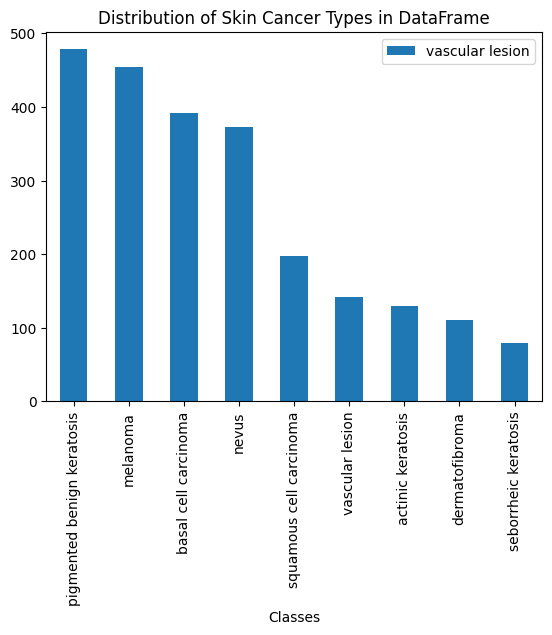

In [47]:
ratio = df['Classes'].value_counts()
ratio.plot(kind='bar')
plt.title('Distribution of Skin Cancer Types in DataFrame')
plt.legend(df['Classes'].unique())
plt.show()

Dataset split + Subset of 1000 images + Resizing

In [60]:
ImageSize = (128, 128)
BatchSize = 32

train_ds = utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode="int",
    batch_size=BatchSize,
    image_size=ImageSize,
    validation_split=0.25,
    shuffle=True,
    seed=123,
    subset="training"
)

val_ds = utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode="int",
    batch_size=BatchSize,
    image_size=ImageSize,
    validation_split=0.25,
    seed=123,
    subset="validation"
)

test_ds = utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode="int",
    batch_size=BatchSize,
    image_size=ImageSize,
    seed=123,
)

# subset_train_ds = train_ds.take(1000)

Found 2239 files belonging to 9 classes.
Using 1680 files for training.
Found 2239 files belonging to 9 classes.
Using 559 files for validation.
Found 118 files belonging to 9 classes.


In [49]:
class_names = train_ds.class_names
print("classes: ", class_names)

classes:  ['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


Balancing Class Weights

In [50]:
y_train = np.concatenate([y.numpy() for x, y in train_ds], axis=0)
classes = np.unique(y_train)

class_weights = compute_class_weight(
    class_weight="balanced",
    classes=classes,
    y=y_train
)

class_weights = dict(zip(classes, class_weights))

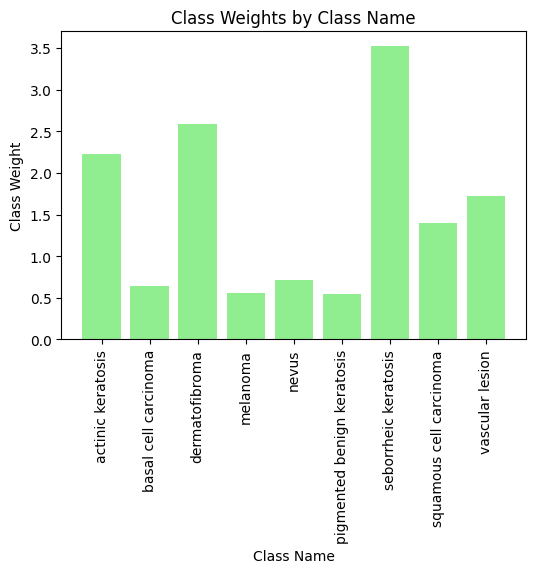

In [51]:
class_names = train_ds.class_names

plt.figure(figsize=(6,4))
plt.bar(class_names, class_weights.values(), color='lightgreen')

plt.xlabel("Class Name")
plt.ylabel("Class Weight")
plt.title("Class Weights by Class Name")
plt.xticks(rotation=90)
plt.show()

Augmentation

In [61]:
# normalization_layer = layers.Rescaling(1./255)

# train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
# val_ds   = val_ds.map(lambda x, y: (normalization_layer(x), y))
# test_ds  = test_ds.map(lambda x, y: (normalization_layer(x), y))

data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))

Random Samples From Data

Shape: (128, 128, 3)
Dtype: <dtype: 'float32'>
Min: 3.0453339
Max: 211.26605


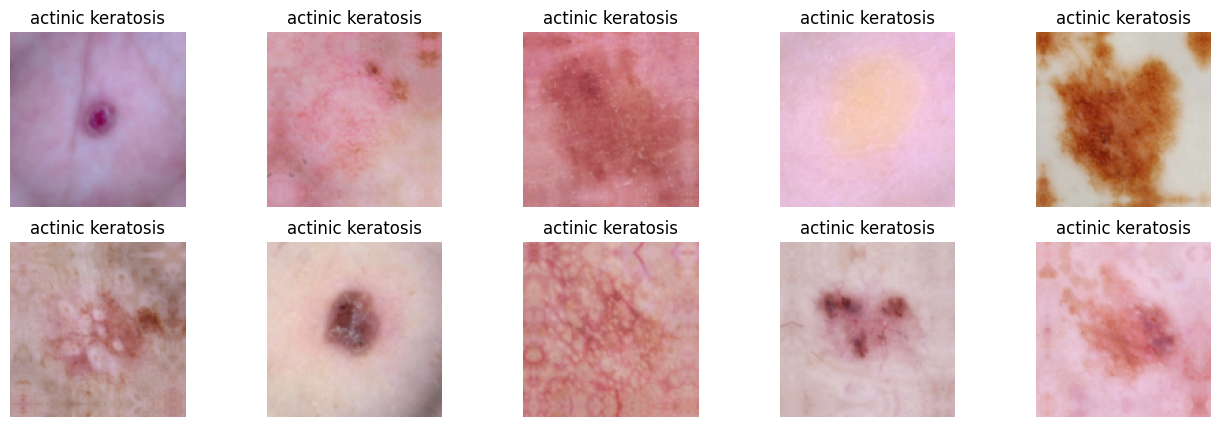

In [62]:
plt.figure(figsize=(16,5))

for images, labels in train_ds.take(1):
  print("Shape:", images[0].shape)
  print("Dtype:", images[0].dtype)
  print("Min:", tf.reduce_min(images[0]).numpy())
  print("Max:", tf.reduce_max(images[0]).numpy())
  for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    label_index = np.argmax(labels[i])
    plt.title(class_names[label_index])
    plt.axis("off")
  plt.show()

Autotune Data

In [63]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Normalizing values using Resnet Preprocess Unit

In [64]:
from tensorflow.keras.applications.resnet50 import preprocess_input

train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))
test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))

model Building

In [78]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128,128,3))
base_model.trainable = False

model = models.Sequential([
    base_model,
    MaxPooling2D(),
    Flatten(),

    Dense(128, activation="relu"),
    BatchNormalization(),
    Dropout(0.4),

    Dense(9, activation="softmax")
])

opti = tf.keras.optimizers.Adam(learning_rate=1e-2)

model.compile(
    optimizer=opti,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'],
)

model.summary()

Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 4, 4, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 2, 2, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 8192)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_28 (Dense)                │ (None, 128)            │     1,048,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_29 (Dense)                │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,638,089 (93.99 MB)

 Trainable params: 1,050,121 (4.01 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

CallBack Function

In [79]:
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.5,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

Model Fitting

In [80]:
history = model.fit(
    train_ds,
    epochs=30,
    validation_data=val_ds,
    callbacks=[early_stop, reduce_lr],
    verbose=2,
    class_weight=class_weights
)

Epoch 1/30
53/53 - 153s - 3s/step - accuracy: 0.3143 - loss: 1.9467 - val_accuracy: 0.3453 - val_loss: 2.8918 - learning_rate: 0.0100
Epoch 2/30
53/53 - 142s - 3s/step - accuracy: 0.5286 - loss: 1.2030 - val_accuracy: 0.5313 - val_loss: 1.7706 - learning_rate: 0.0100
Epoch 3/30
53/53 - 142s - 3s/step - accuracy: 0.6345 - loss: 0.8938 - val_accuracy: 0.4401 - val_loss: 2.1302 - learning_rate: 0.0100
Epoch 4/30
53/53 - 139s - 3s/step - accuracy: 0.7214 - loss: 0.6561 - val_accuracy: 0.4633 - val_loss: 1.6175 - learning_rate: 0.0100
Epoch 5/30
53/53 - 133s - 3s/step - accuracy: 0.7935 - loss: 0.4787 - val_accuracy: 0.4580 - val_loss: 2.4053 - learning_rate: 0.0100
Epoch 6/30
53/53 - 142s - 3s/step - accuracy: 0.8500 - loss: 0.3731 - val_accuracy: 0.4991 - val_loss: 1.9469 - learning_rate: 0.0100
Epoch 7/30

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
53/53 - 141s - 3s/step - accuracy: 0.8476 - loss: 0.3431 - val_accuracy: 0.4776 - val_loss: 2.4619 - learning

Model Evaluating

In [81]:
tr_test_loss, tr_test_accuracy = model.evaluate(test_ds, verbose=0)

print(f"Test Accuracy: {tr_test_accuracy:.4f}, Test Loss: {tr_test_loss:.4f}")

Test Accuracy: 0.4492, Test Loss: 2.1741


Plotting Accuracy + Loss

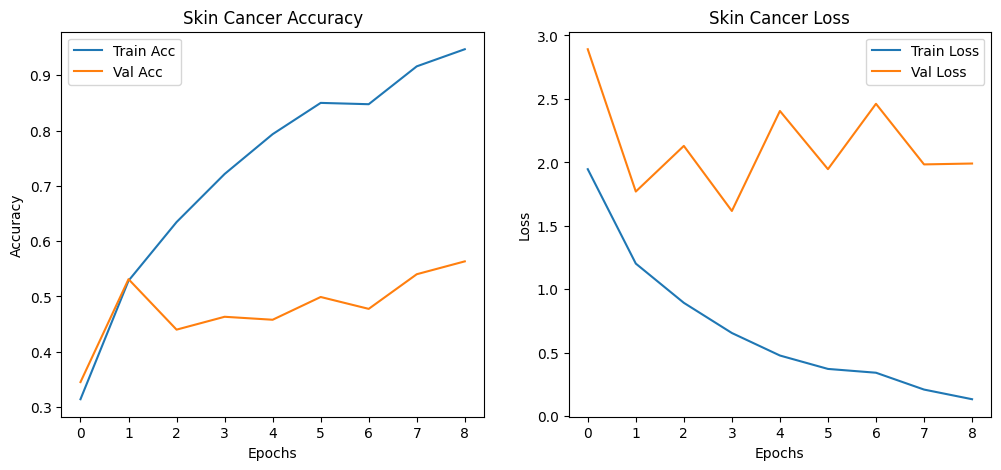

In [82]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Accuracy
ax1.plot(history.history['accuracy'], label='Train Acc')
ax1.plot(history.history['val_accuracy'], label='Val Acc')
ax1.set_title("Skin Cancer Accuracy")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Accuracy")
ax1.legend()

# Loss
ax2.plot(history.history['loss'], label='Train Loss')
ax2.plot(history.history['val_loss'], label='Val Loss')
ax2.set_title("Skin Cancer Loss")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Loss")
ax2.legend()

plt.show()